In [118]:
import sys

sys.path.append('../../code/')
import os
import json
from datetime import datetime
import time
from math import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

import igraph as ig

from load_data import load_citation_network, case_info
from helper_functions import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

data_dir = '../../data/'
court_name = 'all'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load into igraph

In [2]:
start = time.time()
if court_name == 'all':
    case_metadata = pd.read_csv(data_dir + 'clean/case_metadata_master.csv')

    edgelist = pd.read_csv(data_dir + 'clean/edgelist_master.csv')
else:
    net_dir = data_dir + 'clean/' + court_name + '/'
    if not os.path.exists(net_dir):
        os.makedirs(net_dir)
        make_court_subnetwork(court_name, data_dir)

    case_metadata = pd.read_csv(net_dir + 'case_metadata.csv')

    edgelist = pd.read_csv(net_dir + 'edgelist.csv')
    edgelist.drop('Unnamed: 0', inplace=True, axis=1)

# create a dictonary that maps court listener ids to igraph ids
cl_to_ig_id = {}
cl_ids = case_metadata['id'].tolist()
for i in range(case_metadata['id'].size):
    cl_to_ig_id[cl_ids[i]] = i

# add nodes
V = case_metadata.shape[0]
g = ig.Graph(n=V, directed=True)
# g.vs['date'] = case_metadata['date'].tolist()
g.vs['name'] = case_metadata['id'].tolist()

# create igraph edgelist
cases_w_metadata = set(cl_to_ig_id.keys())
ig_edgelist = []
missing_cases = 0
start = time.time()
for row in edgelist.itertuples():

    cl_ing = row[1]
    cl_ed = row[2]

    if (cl_ing in cases_w_metadata) and (cl_ed in cases_w_metadata):
        ing = cl_to_ig_id[cl_ing]
        ed = cl_to_ig_id[cl_ed]
    else:
        missing_cases += 0
    
    ig_edgelist.append((ing, ed))

# add edges to graph
g.add_edges(ig_edgelist)

end = time.time()

print '%d seconds for %d edges' % (end - start, len(g.es))

93 seconds for 24997230 edges


In [3]:
# add vertex attributes
g.vs['court'] =  case_metadata['court'].tolist()
g.vs['year'] = [int(d.split('-')[0]) for d in case_metadata['date'].tolist()]

In [4]:
# g.write_graphml(data_dir + 'clean/entire_law_net.graphml')
# G = ig.read_graphml(data_dir + 'clean/entire_law_net.graphml')

# analyze

In [5]:
g.summary()

'IGRAPH DN-- 3760097 24997230 -- \n+ attr: court (v), name (v), year (v)'

In [164]:
def compute_measure(x, measure, alpha=.1):
    if measure == 'mean':
        return np.mean(x)
    elif measure == 'median':
        return np.median(x)
    elif measure == 'upper_trimed_mean':
        return upper_trimed_mean(x, alpha)
    elif measure == 'max':
        return max(x)
    elif measure == 'n1':
        return sum([v == 1 for v in x])
    elif measure == 'prop1':
        return (sum([v == 1 for v in x]) + 0.0)/len(x)
    else:
        raise ValueError('improper meassure')

In [165]:
def get_degree_trend(g, court='all', include_zero_outdegree=True,
                     measure='mean', alpha=.1):
    
    if measure not in ['mean', 'median', 'upper_trimed_mean', 'max', 'n1', 'prop1']:
        raise ValueError('improper measure')
    
    if court != 'all' and type(court) != list:
        court = set([court])

    year_range = range(1631, 2016 + 1)
    trend = pd.DataFrame(index=year_range, columns=['count', 'indegree', 'outdegree'])

    indegrees = g.indegree()
    outdegrees = g.outdegree()

    year_counts = {y: 0 for y in trend.index}
    indegs_counts = {y: [] for y in trend.index}
    outdegs_counts = {y: [] for y in trend.index}

    # compute statistics for each year
    if court == 'all':
        for i in range(len(g.vs)):
            outdeg = outdegrees[i]
            
            if include_zero_outdegree or outdeg > 0:
                year = g.vs[i]['year']
    
                year_counts[year] += 1
                indegs_counts[year].append(indegrees[i])
                outdegs_counts[year].append(outdeg)                

    else:
        for i in range(len(g.vs)):
            v = g.vs[i]
            if v['court'] in court:
                
                outdeg = outdegrees[i]
                if include_zero_outdegree or outdeg > 0:
                    year = v['year']
                    
                    year_counts[year] += 1
                    indegs_counts[year].append(indegrees[i])
                    outdegs_counts[year].append(outdeg)     

    trend['count'] = year_counts.values()

    # average the degrees by yaer  
    for y in year_counts.keys():
        indegs = indegs_counts[y]
        outdegs = outdegs_counts[y]
        
        if len(indegs) == 0:
            trend.loc[y, 'indegree'] = 0
        else:
            trend.loc[y, 'indegree'] = compute_measure(indegs, measure, alpha=.1)

        if len(outdegs) == 0:
            trend.loc[y, 'outdegree'] = 0
        else:
            trend.loc[y, 'outdegree'] = compute_measure(outdegs, measure, alpha=.1)
    return trend

# Single court trend

In [24]:
def plot_single_trend(trend, court, measure, start_year=1850):
    plt.figure(figsize = [24, 8])
    
    # case count
    plt.subplot(1,3,1)
    plt.scatter(trend.index,
                trend['count'],
                marker='.',
                color='black')
    
    plt.ylim(0, max(trend['count']))
    plt.xlim([start_year, 2016])
    plt.xlabel('year')
    plt.ylabel('number of cases')
    plt.title('case count %s' % court)
    
    # out-degree
    plt.subplot(1,3,2)
    plt.scatter(trend.index,
                trend['outdegree'],
                marker='.',
                color='black')
    plt.ylim(0, max(trend['outdegree']))
    plt.xlim([start_year, 2016])
    plt.xlabel('year')
    plt.ylabel('%s out-degree' % measure)
    plt.title('%s out degree of %s' % (measure, court))
    
    # in-degree
    plt.subplot(1,3,3)
    plt.scatter(trend.index,
                trend['indegree'],
                marker='.',
                color='black')
    plt.ylim(0, max(trend['indegree']))
    plt.xlim([start_year, 2016])
    plt.xlabel('year')
    plt.ylabel('%s in-degree' % measure)
    plt.title('%s in degree of %s' %  (measure, court))
    

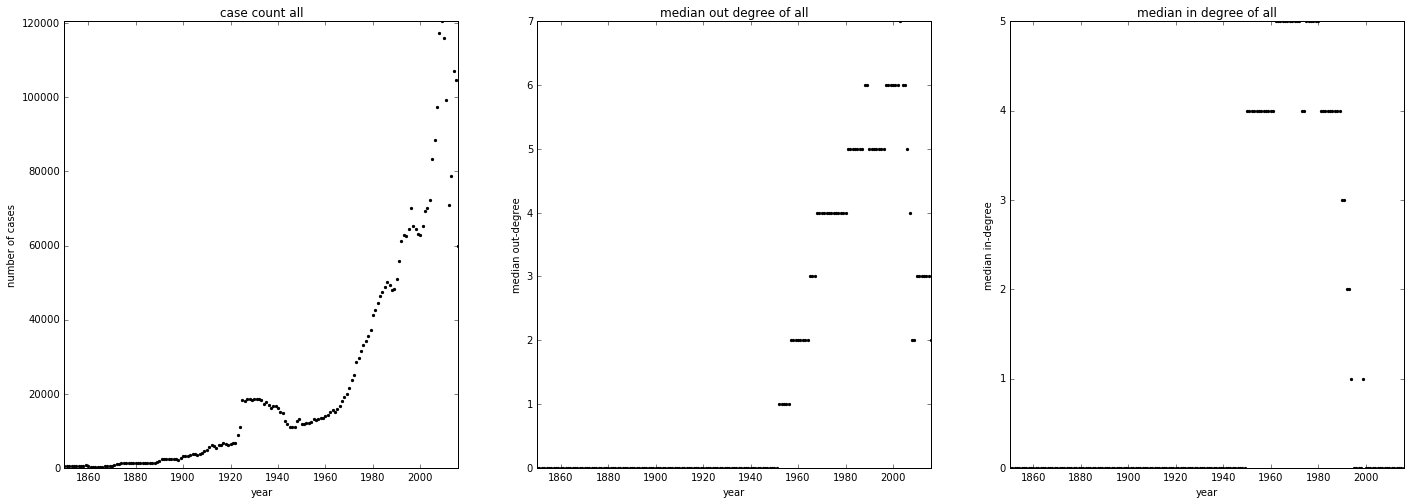

In [25]:
plot_single_trend(trend_all, court='all', measure='median', start_year=1850)

# compare courts

In [126]:
measure = 'upper_trimed_mean'

In [132]:
start = time.time()
trend_scotus = get_degree_trend(g,
                                court='scotus',
                                include_zero_outdegree=False,
                                measure=measure)
end = time.time()
print 'get_degree_trend took %d seconds' % (end-start)

../../code/helper_functions.py:39: UserWarning: over trimming


get_degree_trend took 4 seconds


In [133]:
start = time.time()
trend_ca1 = get_degree_trend(g,
                             court='ca1',
                             include_zero_outdegree=False,
                             measure=measure)

end = time.time()
print 'get_degree_trend took %d seconds' % (end-start)

get_degree_trend took 3 seconds


In [130]:
def plot_compare_trends(A, netA, B, netB, start_year, measure):

    plt.figure(figsize= [20, 10])
    # case count
    plt.subplot(1,2,1)
    plt.scatter(A.index,
                A['count'],
                marker='.',
                color='red',
                label=netA)
    
    plt.scatter(B.index,
                B['count'],
                marker='.',
                color='blue',
                label=netB)
    
    plt.ylim(0, max(A['count'].max(), B['count'].max()))
    plt.xlim([start_year, 2016])
    plt.xlabel('year')
    plt.ylabel('number of cases')
    plt.title('case count of %s vs. %s' % (netA, netB))
    plt.legend(loc='top right')
    
    # out-degree
    plt.subplot(1,2,2)
    plt.scatter(A.index,
                A['outdegree'],
                marker='.',
                color='red',
                label=netA)
    
    plt.scatter(B.index,
                B['outdegree'],
                marker='.',
                color='blue',
                label=netB)
    
    plt.ylim(0, max(A['outdegree'].max(), B['outdegree'].max()))
    plt.xlim([start_year, 2016])
    plt.xlabel('year')
    plt.ylabel('%s out-degree' % measure)
    plt.title('%s out-degree of %s vs. %s' % (measure, netA, netB))
    plt.legend(loc='upper right')

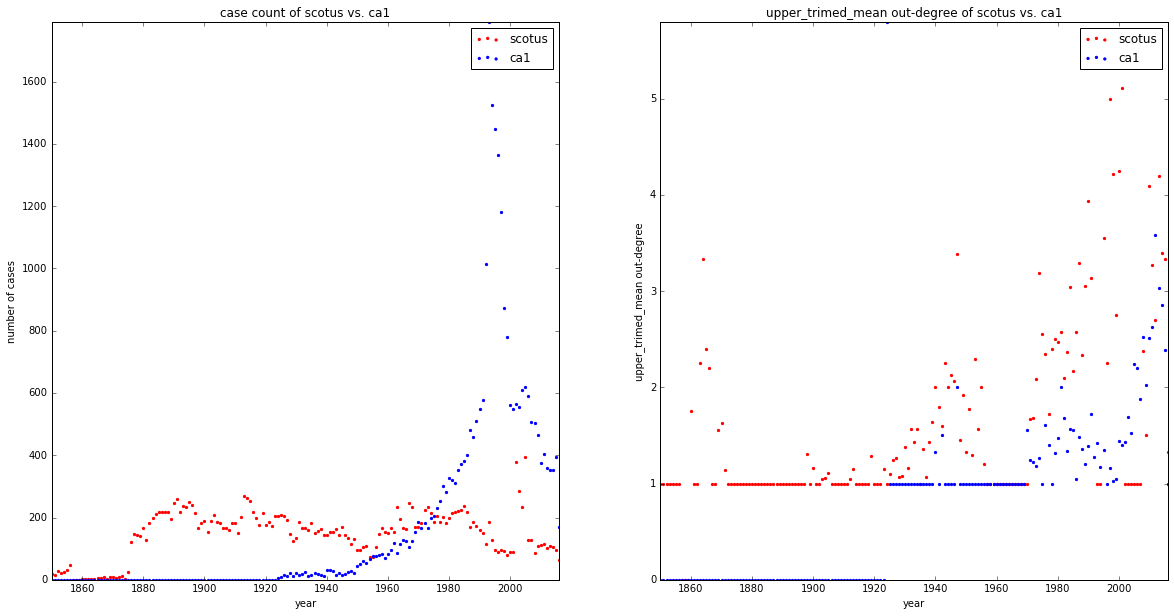

In [134]:
plot_compare_trends(trend_scotus, 'scotus',
                    trend_ca1, 'ca1',
                    start_year=1850,
                    measure=measure)

# compare SCOTUS to federal appellate courts

In [180]:
measure = 'upper_trimed_mean'
# measure = 'prop1'
alpha = .1

In [181]:
fed_appellate = ['ca' + str(i+1) for i in range(11)]
fed_appellate.append('cafc')
fed_appellate.append('cadc')

In [182]:
start = time.time()
trend_scotus = get_degree_trend(g,
                                court='scotus',
                                include_zero_outdegree=False,
                                measure=measure,
                                alpha=alpha)
end = time.time()
print 'get_degree_trend took %d seconds' % (end-start)

get_degree_trend took 4 seconds


In [183]:
start = time.time()
trend_fed_appellate = get_degree_trend(g,
                                       court=fed_appellate,
                                       include_zero_outdegree=False,
                                       measure=measure,
                                       alpha=alpha)

end = time.time()
print 'get_degree_trend took %d seconds' % (end-start)

get_degree_trend took 5 seconds


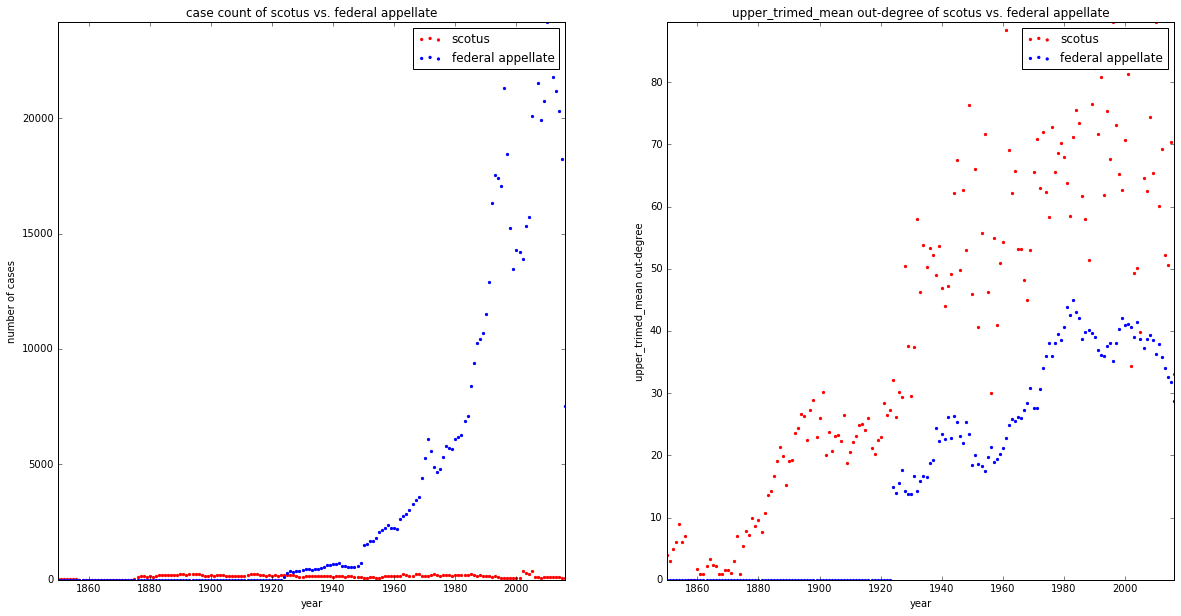

In [184]:
plot_compare_trends(trend_scotus, 'scotus',
                    trend_fed_appellate, 'federal appellate',
                    start_year=1850,
                    measure=measure)

In [ ]:
# def plot_trend_ratio(A, netA, B, netB, measure):
    
    

#     ratio = A['outdegree']
    
#     years = A
    
#     plt.figure(figsize= [20, 10])
#     # case count
#     plt.subplot(1,2,1)
#     plt.scatter(years,
#                 ratio,
#                 marker='.',
#                 color='red',
#                 label=netA)
    

    
#     plt.ylim(0, max(A['count'].max(), B['count'].max()))
#     plt.xlim([start_year, 2016])
#     plt.xlabel('year')
#     plt.ylabel('number of cases')
#     plt.title('case count of %s vs. %s' % (netA, netB))
#     plt.legend(loc='top right')
  

# jurisdiction counts

In [ ]:
jurisdictions = pd.read_csv(data_dir + 'clean/jurisdictions.csv')

In [99]:
jurisdictions.sort_values(by='count', ascending=False, inplace=True)
print_full(jurisdictions, ['name', 'count'])